In [1]:
# Set up the environment
from matplotlib import pyplot as plt
from myst_nb import glue

import numpy as np

import xml_book.meta_explainers.plot_examples as plot_examples
import xml_book.plots.arrays as arrays

(text:meta-explainers:surrogates:overview)=
# Overview #

To better understand surrogate explainers, we discuss them on multiple levels: abstract, theoretical and algorithmic, for image, text and tabular data.
Next, we overview explanations that can be generated with surrogate trees and linear models; introduce evaluation criteria and strategies; go through caveats of surrogate explainers; and present relevant literature.
You can navigate through these sections using the right-hand side *Contents* panel.

````{admonition} Mathematical Notation Summary
:class: note, dropdown

```{list-table}
:header-rows: 1
:name: text:meta-explainers:surrogates:maths

* - Symbol
  - Meaning
* - $\mathcal{X}$
  - Original representation of data.
* - $\mathcal{X}^\prime$
  - Interpretable representation of data.
* - $X$
  - A subset of data in the original representation $X \subset \mathcal{X}$.
* - $X^\prime$
  - A subset of data in the interpretable representation $X^\prime \subset \mathcal{X}^\prime$.
* - $x$
  - A data point in the original representation $x \in \mathcal{X}$.
* - $x^\prime$
  - A data point in the interpretable representation $x^\prime \in \mathcal{X}^\prime$.
* - $\mathring{x}$
  - A data point selected to be explained in the original representation $\mathring{x} \in \mathcal{X}$.
* - $\mathring{x}^\prime$
  - A data point selected to be explained in the interpretable representation $\mathring{x}^\prime \in \mathcal{X}^\prime$.
* - $\mathcal{Y}$
  - The label space of the data $\mathcal{X}$.
    For crisp classification it encodes unique classes $c \in \mathcal{Y}$;
    for probabilistic classification $\mathcal{Y} \;\colon= \left[ 0, 1 \right]^C$, where $C$ is the set of all classes and $c \in C$ denotes an individual class; and
    for regression it is a numerical range, e.g., $\mathcal{Y} \equiv \mathbb{R}$.
* - $Y$
  - Labels $Y \subset \mathcal{Y}$ for a subset of data $X \subset \mathcal{X}$.
* - $\mathring{C}$
  - A subset of classes $\mathring{C} \subseteq \mathcal{Y}$ selected to be explained.
* - $\mathring{c}$
  - A class $\mathring{c} \in \mathcal{Y}$ selected to be explained.
* - $d$
  - Dimensionality -- i.e., number of features -- of the data space $\mathcal{X}$.
* - $\mathcal{F}$
  - A family of black-box models compatible with the explainer.
* - $f \in \mathcal{F} : \mathcal{X} \rightarrow \mathcal{Y}$
  - A black-box model being investigated.
    If the model is probabilistic or crisp classifier, a subscript $c$ -- i.e., $f_c$ -- is used to indicate that it outputs: a probability of class $c$ for the former type; and for the latter $1$ if the predicted class is $c$ and $0$ otherwise.
* - $\mathcal{G}$
  - A family of inherently transparent and human-comprehensible models that can be used as surrogates.
* - $g \in \mathcal{G} : \mathcal{X}$ or $\mathcal{X}^\prime \rightarrow [0, 1]$ or $\{0, 1\}$ or $\mathcal{Y}$
  - A surrogate model fitted to the original $\mathcal{X}$ (specific to tabular) or interpretable $\mathcal{X}^\prime$ (tabular, image and text) data representation;
    and a probability of a selected class ($[0, 1]$) for probabilistic classifiers, the $\{0, 1\}$ encoding of a selected class for crisp models, and a numerical output for regressors.
* - $\IR : \mathcal{X} \rightarrow \mathcal{X}^\prime$
  - A transformation function from the original into the interpretable domain.
    The inverse transformation is dented with $\IR^{-1}$.
* - $L : \mathcal{X} \times \mathcal{X}$ or $\mathcal{X}^\prime \times \mathcal{X}^\prime \rightarrow \mathbb{R}$
  - A distance metric compatible with either the original $\mathcal{X}$ or $\mathcal{X}^\prime$ data domains.
* - $k : \mathbb{R} \rightarrow \mathbb{R}$
  - A kernel transforming distances into similarity scores.
* - $\Omega : \mathcal{G} \rightarrow \mathbb{R}$
  - A function that measures complexity of a surrogate model as perceived by a human {term}`explainee`; for example the number of non-zero parameters in a linear model or a size (depth or width) of a decision tree.
* - $\mathcal{L} : \mathcal{F} \times \mathcal{G} \rightarrow \mathbb{R}$
  - A function that calculates the quality of a surrogate model by assessing how well it mimics the predictions of the explained black box (also known as {term}`fidelity`).
* - ${\Large\mathbb{1}} : \mathbb{R} \rightarrow \{0, 1\}$
  - An indicator function for a specific condition, e.g.,
    ${\Large\mathbb{1}}\left(x\right) =
     \begin{cases}
       1, & \text{if} \;\; x > 0\\
       0, & \text{otherwise}
     \end{cases}$.
```
````

## Building Surrogates ##

The introduction to {numref}`Chapter %s<text:meta-explainers:surrogates>` provided a high-level overview of surrogate explainers.
It also introduced the three fundamental components of the {term}`bLIMEy` framework, which can be codified in a meta-algorithm (the steps of {prf:ref}`algo:meta-explainers:surrogates:blimey` corresponding to each module are given in parentheses):

* interpretable data representation composition (step 1);
* data sampling (steps 2--4); and
* explanation generation (steps 5--8).

In this process, $\IR : \mathcal{X} \rightarrow \mathcal{X}^\prime$ is a function transforming data from their original domain $\mathcal{X}$ into the interpretable representation $\mathcal{X}^\prime$;
$X \subset \mathcal{X}$ and $X^\prime \subset \mathcal{X}^\prime$ are the sampled data respectively in their original and interpretable representations;
$f \in \mathcal{F} : \mathcal{X} \rightarrow \mathcal{Y}$ is the black-box model being explained, with a $\mathring{c}$ subscript -- i.e., $f_\mathring{c}$ -- indicating the class to be predicted (and explained);
$L : \mathcal{X}^\prime \times \mathcal{X}^\prime \rightarrow \mathbb{R}$ is a distance metric; and
$k : \mathbb{R} \rightarrow \mathbb{R}$ is a kernel transforming distances into similarity scores.
Note that sampling (step 2) and distance calculation (step 5) are done in the interpretable domain $\mathcal{X}^\prime$, but these operations can also be performed in the original domain $\mathcal{X}$ (with certain caveats).
Additionally, the order of steps 5 and 6 -- which are *optional* -- can be reversed.
Refer to the *{ref}`Mathematical Notation Summary<text:meta-explainers:surrogates:maths>`* box at the top of this page for an overview of mathematical notation used throughout this chapter.

```{prf:algorithm} bLIMEy meta-algorithm
:label: algo:meta-explainers:surrogates:blimey

**Inputs** Given an instance to be explained $\mathring{x}$, a class to be explained $\mathring{c}$ and a black-box model $f$

**Output** Compute an explanation $e$

1. $\mathring{x}^\prime \gets \IR(\mathring{x})$
2. $X^\prime \gets \mathtt{sample\_data}(\mathring{x}^\prime, \;\; \mathtt{scope}=\{\mathtt{local},\; \mathtt{cohort},\; \mathtt{global}\})$ *(performed in $\mathcal{X}^\prime$)*
3. $X \gets \IR^{-1}(X^\prime)$
4. $y \gets f_\mathring{c}(X)$
5. $w \gets k(L(\mathring{x}^\prime, \; X^\prime))$ *(get weights via kernelised distance)*
6. $\overline{X}^\prime \gets \mathtt{reduce\_dimensionality}(X^\prime)$
7.  $g \gets \mathtt{fit\_surrogate}(\overline{X}^\prime, \; y, \; \mathtt{sample\_weight}=w)$
8.  $e \gets \mathtt{extract\_explanation}(g)$
```

A concrete example of this meta-algorithm for two-dimensional tabular data with numerical features is shown in {numref}`fig:surrogates:full_overview`.
In this particular case, an interpretable representation is not used to offer more clarity and a better intuition of the process.
Therefore, the representation transformations are not needed (steps 1 and 3);
the data are sampled in their original domain $\mathcal{X}$ (step 2);
the distance is computed in the original domain $\mathcal{X}$ as well (step 5);
the dimensionality reduction is not needed (step 6); and
the surrogate if fitted into the data sample in the original domain $\mathcal{X}$ (step 7).

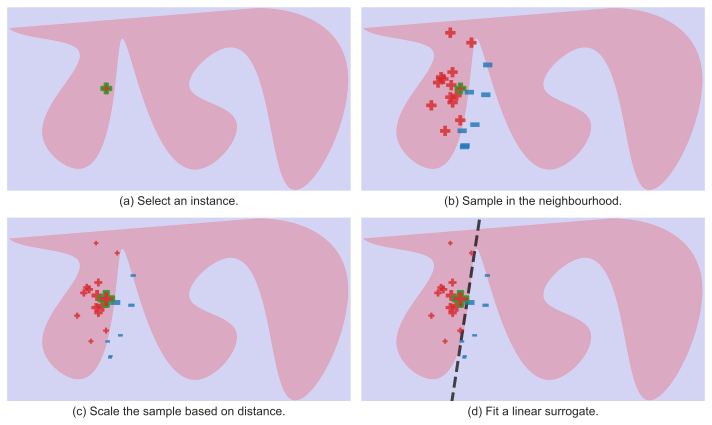

<Figure size 720x432 with 0 Axes>

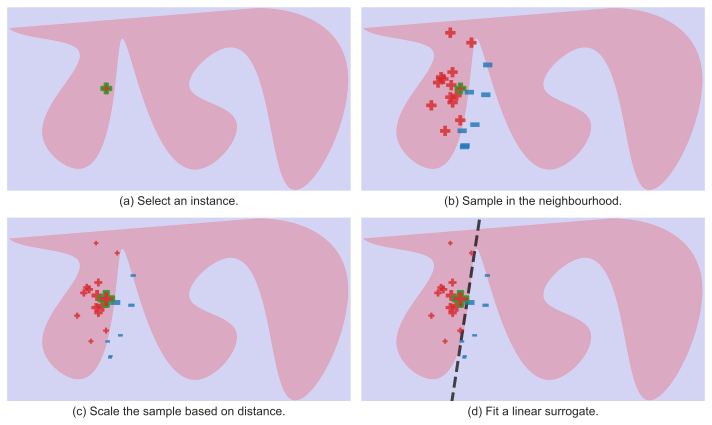

In [2]:
figsize_all = (2 * 5, 2 * 3)
fig = plt.figure(figsize=figsize_all)
fig, ax = plt.subplots(2, 2, figsize=figsize_all)

figsize_piece = (5, 3)
title_loc = -0.11
fig1, ax1 = plot_examples.local_linear_surrogate_advanced(
    plot_axis=ax[0, 0], figsize=figsize_piece,
    plot_line=False, scale_points=False, plot_sample=False)
ax1.set_title('(a) Select an instance.', y=title_loc)
fig2, ax2 = plot_examples.local_linear_surrogate_advanced(
    plot_axis=ax[0, 1], figsize=figsize_piece, plot_line=False, scale_points=False)
ax2.set_title('(b) Sample in the neighbourhood.', y=title_loc)
fig3, ax3 = plot_examples.local_linear_surrogate_advanced(
    plot_axis=ax[1, 0], figsize=figsize_piece, plot_line=False, scale_points=True)
ax3.set_title('(c) Scale the sample based on distance.', y=title_loc)
fig4, ax4 = plot_examples.local_linear_surrogate_advanced(
    plot_axis=ax[1, 1], figsize=figsize_piece, plot_line=True, scale_points=True)
ax4.set_title('(d) Fit a linear surrogate.', y=title_loc)

glue('fig_surrogates_fullOverview', fig, display=False)

```{glue:figure} fig_surrogates_fullOverview
:figwidth: 95%
:name: "fig:surrogates:full_overview"

Steps required to build a *local*, *linear* surrogate explainer for *tabular data* without an interpretable representation.
Panel (a) shows an instance selected to be explained for the black box whose decision boundary is shown by the blue and red background shading.
Panel (b) depicts a collection of data sampled locally around the explained instance.
Panel (c) illustrates distance-based weighting of this data sample.
Finally, Panel (d) captures a surrogate linear model approximating the black-box decision boundary in this region.
```

Formally, surrogates are built by optimising the objective $\mathcal{O}$ given in {eq}`eq:meta-explainers:surrogates:optimisation`.
It balances the (human {term}`explainee`-perceived) complexity $\Omega : \mathcal{G} \rightarrow \mathbb{R}$ of the surrogate model $g \in \mathcal{G}$, which is chosen from the space of a transparent family of models $\mathcal{G}$, against its ability to approximate the explained black box $\mathcal{L} : \mathcal{F} \times \mathcal{G} \rightarrow \mathbb{R}$, where $f \in \mathcal{F}$ is the opaque model drawn from a family of models $\mathcal{F}$ compatible with this explainer.

$$
  \mathcal{O}(\mathcal{G}; \; f) =
  \argmin_{g \in \mathcal{G}}
  \overbrace{\Omega(g)}^{\text{complexity}} \; + \;\;\;
  \overbrace{\mathcal{L}(f, g)}^{\text{fidelity}}
$$ (eq:meta-explainers:surrogates:optimisation)

For example, the complexity $\Omega$ can be the number of non-zero (or *substantially* larger than zero) parameters of a linear model ({eq}`eq:meta-explainers:surrogates:complexity-linear`, where $\Theta_g$ are the coefficients of the surrogate and ${\Large\mathbb{1}} : \mathbb{R} \rightarrow \{0, 1\}$ is an indicator function), or the size -- depth or width -- of a decision tree ({eq}`eq:meta-explainers:surrogates:complexity-tree`, where $d$ is the dimensionality of the data space $\mathcal{X}$).

$$
  \Omega(g) = \frac{\sum_{\theta \in \Theta_g} {\Large\mathbb{1}} \left(\theta\right)}{|\Theta_g|}
$$ (eq:meta-explainers:surrogates:complexity-linear)

$$
  \Omega(g; \; d) = \frac{\text{depth}(g)}{d}
  \;\;\;\;\text{or}\;\;\;\;
  \Omega(g; \; d) = \frac{\text{width}(g)}{2^d}
$$ (eq:meta-explainers:surrogates:complexity-tree)

The second component of the optimisation objective $\mathcal{O}$ -- the {term}`fidelity` of the surrogate explainer $\mathcal{L} : \mathcal{F} \times \mathcal{G} \rightarrow \mathbb{R}$ -- measures how well it mimics the predictions of the explained black box (more specifically, its decision surface contained within the subspace of interest).

The formulation of fidelity $\mathcal{L}$ depends on the type of the explained black box.
For *regressors* and *probabilistic classifiers* it is based on a weighted -- determined by the proximity of each instance to the explained data point -- squared error; in the latter scenario the numerical optimisation uses the probability of a single class $\mathring{c}$ selected to be explained.
{eq}`eq:meta-explainers:surrogates:loss-regression` defines the loss for these two cases, with the evaluation performed on a data set $X^\prime$ captured in the interpretable representation $\mathcal{X}^\prime$, the surrogate model $g$ operating on the interpretable domain $\mathcal{X}^\prime$ as well, and the weighting $k(L(\cdot, \cdot))$ also done in the interpretable space $\mathcal{X}^\prime$.

$$
  \mathcal{L}(f, g ; \; \mathring{x}, X^\prime, \mathring{c}) =
  \sum_{x^\prime \in X^\prime} \;
  \underbrace{k\left(L\left(\IR(\mathring{x}), \; x^\prime\right)\right)}_{\text{weighting factor}}
  \; \times \;
  \underbrace{\left(f_\mathring{c}\left(\IR^{-1}(x^\prime)\right) - g(x^\prime)\right)^{2}}_{\text{individual loss}}
$$ (eq:meta-explainers:surrogates:loss-regression)

The loss $\mathcal{L}$ for *crisp classification*, on the other hand, is inspired by predictive accuracy -- see {eq}`eq:meta-explainers:surrogates:loss-classification`.
Here, the *individual loss* component is based on an indicator function whose role depends on whether the black box is a binary or multi-class classifier and how the local model was trained.
Specifically, after choosing a class to be explained $\mathring{c}$, the target becomes $1$ if it is this class and $0$ otherwise -- XXX which is also used to train the surrogate.
For example, TODO

In [3]:
array = np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]])
mathjax = '<span class="math">\\({}\\)</span>'
labels = [mathjax.format('\\mathring{c}'),
          mathjax.format('\\mathring{b}'), 
          mathjax.format('\\mathring{a}')]
table = arrays.DisplayArray(array,
                            numerical_precision=2,
                            column_names=labels,
                            centre=True)
glue('tab_surrogates_classProc', table, display=False)

\(\mathring{c}\),\(\mathring{b}\),\(\mathring{a}\)
1.00,2.00,3.00
1.00,2.00,3.00
1.00,2.00,3.00
1.00,2.00,3.00


```{glue:} tab_surrogates_classProc
```

TODO

$$
  \mathcal{L}(f, g ; \; \mathring{x}, X^\prime, \mathring{c}) =
  \sum_{x^\prime \in X^\prime} \;
  k\left(L\left(\IR(\mathring{x}), \; x^\prime\right)\right)
  \; \times \;
  \underline{ {\Large\mathbb{1}} \left(f_\mathring{c}\left(\IR^{-1}(x^\prime)\right), \; g(x^\prime)\right)}
$$ (eq:meta-explainers:surrogates:loss-classification)

Note that the *weights* can be computed with the distance metric applied to either the original $\mathcal{X}$ -- i.e., $k\left(L\left(\mathring{x}, x\right)\right)$ -- or the interpretable $\mathcal{X}^\prime$ -- i.e., $k\left(L\left(\IR(\mathring{x}), x^\prime\right)\right)$ -- domain.
Similarly, the surrogate model my be fitted to the original $\mathcal{X}$ -- i.e., $\left(f_\mathring{c}\left(x\right), g(x)\right)$ -- or the interpretable $\mathcal{X}^\prime$ -- i.e., $\left(f_\mathring{c}\left(\IR^{-1}(x^\prime)\right), g(x^\prime)\right)$ -- domain.

this -- as well as the algo -- assume a local explanation of a single instance, hence the weighting, in case of other scope, different weighting approaches can be used.


In certain case when modelling multiple classes we may want to capture the complex behaviour,
This can be achieved with multi-output surrogates {cite:p}`sokol2020limetree`.

$$
  \mathcal{L}(f, g ; \; \mathring{x}, X^\prime, \mathring{C}) =
  \frac{1}{\sum_{x^\prime \in X^\prime} \omega(x^\prime; \; \mathring{x})}
  \sum_{x^\prime \in X^\prime} \left(
  \omega(x^\prime; \; \mathring{x}) \times
  \frac{1}{2}\sum_{\mathring{c} \in \mathring{C}}
  \left(f_\mathring{c}\left(\IR^{-1}(x^\prime)\right) -
  g_\mathring{c}(x^\prime)\right)^2
  \right)
$$ (eq:meta-explainers:surrogates:loss-multioutput)

where

$$
  \omega(x^\prime; \; \mathring{x}) = k\left(L\left(\IR(\mathring{x}), x^\prime\right)\right)
$$

## Surrogates Across Data Types ##

The building blocks of surrogate explainers .
TODO

Interpretable Representations XXX -- generic description

### Text ###

**{ref}`Interpretable Representation.<text:meta-explainers:surrogates:image:interpretable-representation>`**
TODO

**Data Sampling.**
TODO

**Explanation Generation.**
TODO

{numref}`Overview (§%s)<text:meta-explainers:surrogates:image>`
{numref}`Overview (§%s)<text:meta-explainers:surrogates:tabular>`
{numref}`Interpretable Representation (§%s)<text:meta-explainers:surrogates:image:interpretable-representation>`
{numref}`Interpretable Representation (§%s)<text:meta-explainers:surrogates:tabular:interpretable-representation>`
{numref}`Data Sampling (§%s)<text:meta-explainers:surrogates:image:data-sampling>`
{numref}`Data Sampling (§%s)<text:meta-explainers:surrogates:tabular:data-sampling>`
{numref}`Explanation Generation (§%s)<text:meta-explainers:surrogates:image:explanation-generation>`
{numref}`Explanation Generation (§%s)<text:meta-explainers:surrogates:tabular:explanation-generation>`

### Images ###

### Tabular Data ###

```{warning}
The official implementation of LIME[^lime_implementation] samples tabular data from the interpretable domain.
This has two major consequences.

1. The sampling is actually global, with locality introduced only via instance weighting.
2. Since the sampled instances need to be restored back to the original representation to xxx, etc.
```

each component brings in assumptions and limitation that permeate to affect the resulting explanations

TODO complexity for tree
TODO complexity for line

## Explanations ##

varying scope

concept influence

counterfactuals, e.g., with trees cite LIMEtree

### Linear ###

### Tree ###

### Multi-output Tree ###

## Evaluation ##

Algorithmic evaluation of surrogates xxx
eval components
and fidelity of explanations

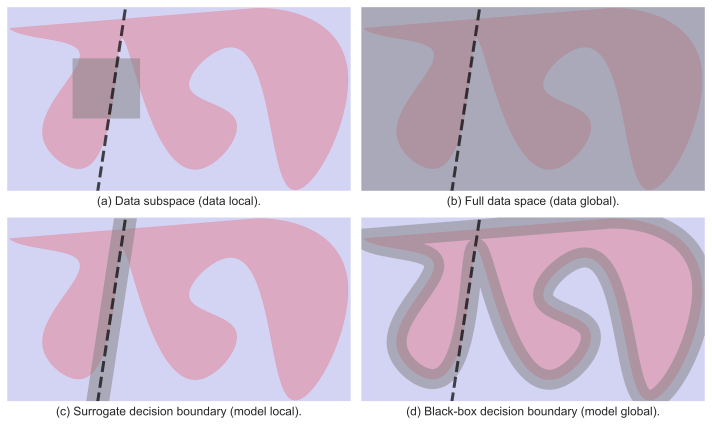

<Figure size 720x432 with 0 Axes>

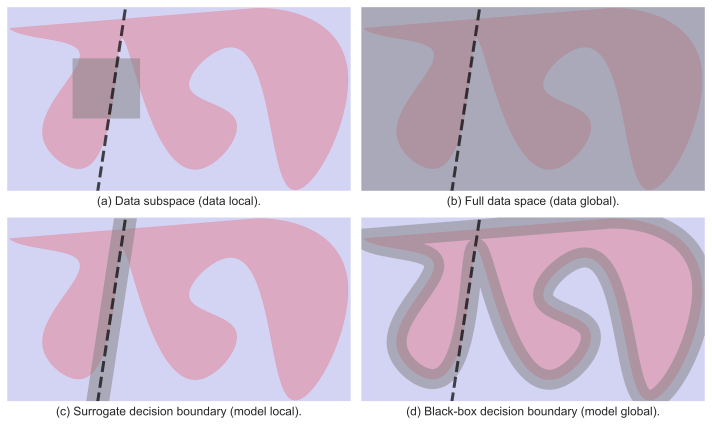

In [4]:
figsize_all = (2 * 5, 2 * 3)
fig = plt.figure(figsize=figsize_all)
fig, ax = plt.subplots(2, 2, figsize=figsize_all)

figsize_piece = (5, 3)
title_loc = -0.11
fig1, ax1 = plot_examples.local_linear_surrogate(
    plot_axis=ax[0, 0], figsize=figsize_piece, eval='inst-loc')
ax1.set_title('(a) Data subspace (data local).', y=title_loc)
fig2, ax2 = plot_examples.local_linear_surrogate(
    plot_axis=ax[0, 1], figsize=figsize_piece, eval='inst-glob')
ax2.set_title('(b) Full data space (data global).', y=title_loc)
fig3, ax3 = plot_examples.local_linear_surrogate(
    plot_axis=ax[1, 0], figsize=figsize_piece, eval='mod-loc')
ax3.set_title('(c) Surrogate decision boundary (model local).', y=title_loc)
fig4, ax4 = plot_examples.local_linear_surrogate(
    plot_axis=ax[1, 1], figsize=figsize_piece, eval='mod-glob')
ax4.set_title('(d) Black-box decision boundary (model global).', y=title_loc)

glue('fig_surrogates_eval', fig, display=False)

```{glue:figure} fig_surrogates_eval
:figwidth: 95%
:name: "fig:surrogates:eval"

Overview of fidelity-based evaluation strategies for surrogates of *tabular* data, using the example of a *local*, *linear* explainer without an interpretable representation.
Panels (a) and (b) show *data-driven* evaluation approaches; the former for a data subspace and the latter for the entire data space (gray shading).
Panels (c) and (d) depict *model-driven* evaluation approaches; the former for the local (surrogate) decision boundary and the latter for the global (black-box) decision boundary.
```

different strategies for tabular data, images can only eb evaluated withing the scope of a single image or sentence.


intuitive visualisation for the local and global, model specific and data-specific visualisations from the thesis.

## Caveats ##

fidelity
stochasticity: random sampling, operating on interpretable representation of tabular data

(text:meta-explainers:surrogates:overview:literature)=
## Additional Materials ##

Do a quick overview of surrogate literature.

popular examples are treepan {cite:p}`craven1996extracting` and LIME {cite:p}`ribeiro2016why`,
and a generalisation fo LIME bLIMEy, which is modular meta-algorithm for building surrogates